<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_10/Part_B/Assignment_10_B_anchor_boxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Refernce Links

https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

https://www.youtube.com/watch?v=4b5d3muPQmA

In [31]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from matplotlib.patches import Rectangle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
raw = pd.read_csv('/content/drive/MyDrive/EVA_6 /sample_coco.txt', names=['id',  'height',  'width',  'X', 'Y', 'b_h', "b_w", "NA"]).drop(['NA'], axis=1)
raw

,id,height,width,X,Y,b_h,b_w
0,id: 0,height: 330,width: 1093,bbox:[69,464,312,175]
1,id: 1,height: 782,width: 439,bbox:[359,292,83,199]
2,id: 3,height: 645,width: 831,bbox:[297,312,267,167]
3,id: 34,height: 943,width: 608,bbox:[275,112,319,290]
4,id: 20,height: 593,width: 857,bbox:[71,368,146,147]
...,...,...,...,...,...,...,...
10100,id: 2,height: 285,width: 550,bbox:[62,129,234,142]
10101,id: 37,height: 735,width: 340,bbox:[389,78,140,158]
10102,id: 15,height: 677,width: 665,bbox:[359,240,297,258]
10103,id: 69,height: 474,width: 653,bbox:[95,168,271,138]


In [4]:
data = pd.DataFrame()
data['id'] = raw['id'].astype(str).str[4:].astype(int)
data['height'] = raw['height'].astype(str).str[8:].astype(int)
data['width'] = raw['width'].astype(str).str[7:].astype(int)
data['X'] = raw['X'].astype(str).str[7:].astype(int)
data['Y'] = raw['Y'].astype(int)
data['b_h'] = raw['b_h'].astype(int)
data['b_w'] = raw['b_w'].astype(str).str[:-1].astype(int)

In [5]:
data.columns

Index(['id', 'height', 'width', 'X', 'Y', 'b_h', 'b_w'], dtype='object')

In [6]:
data.head()

,id,height,width,X,Y,b_h,b_w
0,0,330,1093,69,464,312,175
1,1,782,439,359,292,83,199
2,3,645,831,297,312,267,167
3,34,943,608,275,112,319,290
4,20,593,857,71,368,146,147


In [7]:
data['X_norm'] = data['X']/data['height']
data['Y_norm'] = data['Y']/data['width']
data['b_h_norm'] = data['b_h']/data['height']
data['b_w_norm'] = data['b_w']/data['width']
data

,id,height,width,X,Y,b_h,b_w,X_norm,Y_norm,b_h_norm,b_w_norm
0,0,330,1093,69,464,312,175,0.209091,0.424520,0.945455,0.160110
1,1,782,439,359,292,83,199,0.459079,0.665148,0.106138,0.453303
2,3,645,831,297,312,267,167,0.460465,0.375451,0.413953,0.200963
3,34,943,608,275,112,319,290,0.291622,0.184211,0.338282,0.476974
4,20,593,857,71,368,146,147,0.119730,0.429405,0.246206,0.171529
...,...,...,...,...,...,...,...,...,...,...,...
10100,2,285,550,62,129,234,142,0.217544,0.234545,0.821053,0.258182
10101,37,735,340,389,78,140,158,0.529252,0.229412,0.190476,0.464706
10102,15,677,665,359,240,297,258,0.530281,0.360902,0.438700,0.387970
10103,69,474,653,95,168,271,138,0.200422,0.257274,0.571730,0.211332


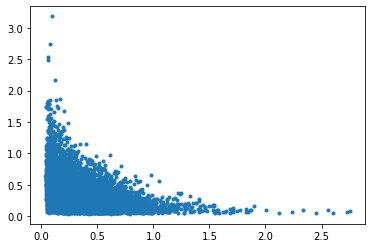

In [8]:
plt.plot(data['b_w_norm'],data['b_h_norm'],'.')

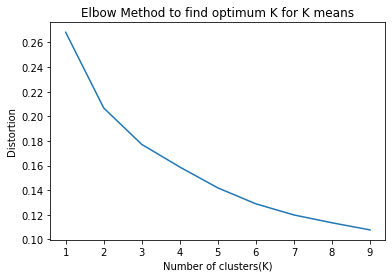

In [17]:
finding_k = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data[['b_h_norm', 'b_w_norm']])
    finding_k.append(sum(np.min(cdist(data[['b_h_norm', 'b_w_norm']], kmeans.cluster_centers_, 'euclidean'), axis=1)) /data[['b_h_norm', 'b_w_norm']].shape[0])
plt.plot(range(1, 10), finding_k)
plt.title('Elbow Method to find optimum K for K means')
plt.xlabel('Number of clusters(K)')
plt.ylabel('Distortion')
plt.show()

## Iou Method to find out K

### IOU(Intersection over union) = intersected area of bbox and anchor box/ Union area of bbox and anchor box

- bw = bounding box width, bh - bounding box height, aw - anchor box width, ah - anchor box height
- IOU = min(bw,aw) min(bh, ah)/bwbh + awah - min(bw,aw) min(bh, ah)
- mean IOU = sum(IOU)/len(IOU)

In [24]:
height = list(data['b_h_norm'])
width = list(data['b_w_norm'])
ks = range(1,10)
meaniou = []
for k in ks:
    cl = KMeans(n_clusters=k)
    cl.fit(data[['b_h_norm', 'b_w_norm']])
    cx = []
    cy = []
    mapcx  = {}
    mapcy = {}
    iou = []
    for i in range(len(data)):
        l = cl.labels_[i]
        cx.append(cl.cluster_centers_[l][0])
        cy.append(cl.cluster_centers_[l][1])
        iou.append(min(width[i] ,cx[i])* min(height[i] , cy[i])/(height[i]*width[i]+ cx[i]*cy[i]- min(width[i] , cx[i])* min(height[i] ,cy[i])))
    meaniou.append(sum(iou)/len(data))

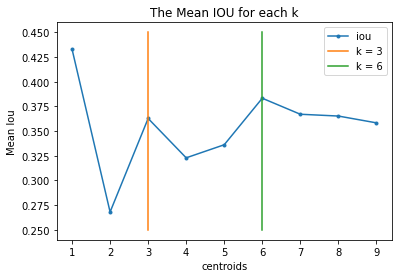

In [65]:
plt.plot(range(1,10),meaniou,'.-',label = "iou")
plt.plot([3,3],[0.25,0.45],label = "k = 3")
plt.plot([6,6],[0.25,0.45],label = "k = 6")
plt.xlabel('centroids')
plt.ylabel('Mean Iou')
plt.title('The Mean IOU for each k')
plt.legend()
plt.show()

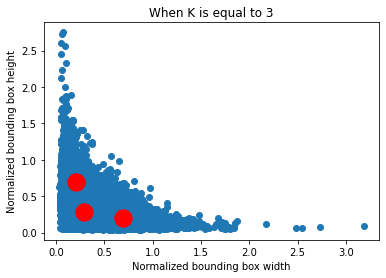

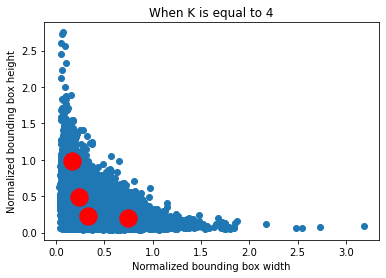

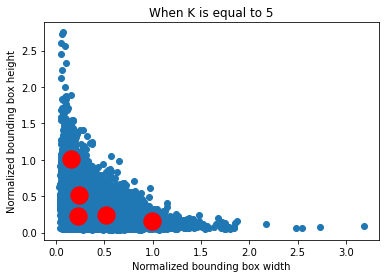

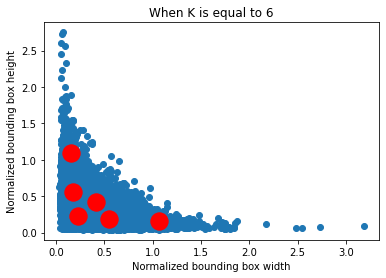

In [28]:
for i in range(3,7):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(data[['b_h_norm', 'b_w_norm']])

    
    plt.scatter(data[['b_h_norm']], data[[ 'b_w_norm']])
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
    plt.title(f'When K is equal to {i}')
    plt.xlabel('Normalized bounding box width')
    plt.ylabel('Normalized bounding box height')  
    plt.show()

Anchor Boxes Centroids
[[0.28711913 0.28974134]
 [0.20134954 0.69289688]
 [0.69201832 0.20031795]]


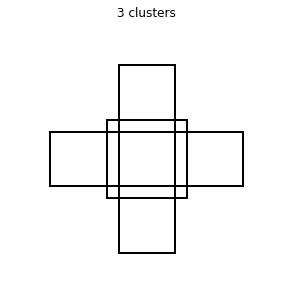

Anchor Boxes Centroids
[[0.23465354 0.49395323]
 [0.74280724 0.20139058]
 [0.3259426  0.22350963]
 [0.15940826 0.99057558]]


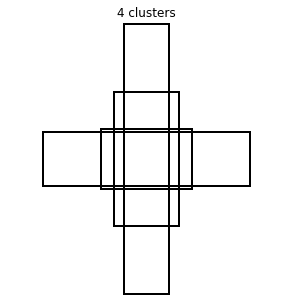

Anchor Boxes Centroids
[[0.22692335 0.22548399]
 [0.99619036 0.15402617]
 [0.23484426 0.51352989]
 [0.15753439 1.00474685]
 [0.51136221 0.24406117]]


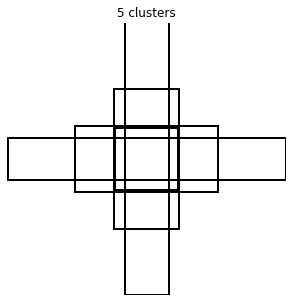

Anchor Boxes Centroids
[[0.17502765 0.5546443 ]
 [0.55018471 0.18121752]
 [0.22389558 0.22449003]
 [0.15414845 1.0917331 ]
 [1.06159694 0.15521382]
 [0.40994462 0.41654505]]


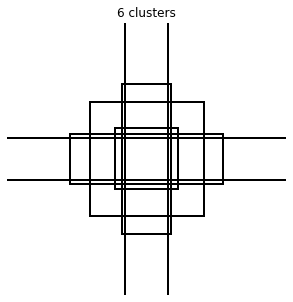

In [63]:
for clusters in range(3,7):
    fig, axes = plt.subplots(1,1,figsize= (5, 5))
    kmeans = KMeans(n_clusters=clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(data[['b_h_norm', 'b_w_norm']])
    anchors = kmeans.cluster_centers_
    for i in range(0, clusters):
        # ax.add_patch(Rectangle((0, 0), anchors[i,0], anchors[i,1],color=plt.cm.RdYlBu(i*40)))
        axes.add_patch(Rectangle((-1*anchors[i][0]/2 + 0.5, -1*anchors[i][1]/2 + 0.5), anchors[i][0], anchors[i][1], fill=False, linewidth=2))
    print("Anchor Boxes Centroids")
    print(kmeans.cluster_centers_)
    axes.set_title(f'{clusters} clusters')
    axes.axis('off')
    plt.show()